In [97]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# 设置字体为支持中文的字体，例如 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正常显示负号
# 加载数据
data = pd.read_excel('weatherofshanghai.xlsx')

# 填充缺失值（如果有）
data.fillna(method='ffill', inplace=True)

data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month


# 天气分类转换为数值
weather_mapping = {'晴': 0, '阴': 1, '雨': 2}
INV_weather_mapping = {v: k for k, v in weather_mapping.items()}
data['天气编码'] = data['天气'].map(weather_mapping)

# 标准化数值数据
scaler = MinMaxScaler()
features = ['平均温度', '平均湿度', '平均气压', '风速', 'month']
input_s = len(features)
output_s = len(features)
# ['最高温度', '最低温度', '平均温度', '最高湿度', '最低湿度', '平均湿度', '风速']

# 筛选 2013 年的数据
data_train = data[(data['date'].dt.year == 2013) | (data['date'].dt.year == 2014) | (data['date'].dt.year == 2015) | (data['date'].dt.year == 2016)]
data_test = data[data['date'].dt.year == 2017]

data_train[features] = scaler.fit_transform(data_train[features])
data_test[features] = scaler.transform(data_test[features])

data_train.head()

C:\Users\24048\AppData\Local\Temp\ipykernel_5280\4094548529.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\24048\AppData\Local\Temp\ipykernel_5280\4094548529.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[features] = scaler.fit_transform(data_train[features])
C:\Users\24048\AppData\Local\Temp\ipykernel_5280\4094548529.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,date,station,city,county,平均气压,风速,平均温度,平均湿度,天气,month,天气编码
0,2013-01-01,上海,上海市,宝山区,0.639659,0.227848,0.218978,0.477612,阴,0.0,1
1,2013-01-02,上海,上海市,宝山区,0.793177,0.569620,0.214112,0.582090,阴,0.0,1
2,2013-01-03,上海,上海市,宝山区,0.970149,0.367089,0.138686,0.597015,阴,0.0,1
3,2013-01-04,上海,上海市,宝山区,0.831557,0.227848,0.172749,0.626866,阴,0.0,1
4,2013-01-05,上海,上海市,宝山区,0.735608,0.164557,0.197080,0.656716,阴,0.0,1


In [98]:
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch
import torch.nn as nn
# 创建序列数据
# 定义时间序列长度
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    X, y_regression, x_classification, y_classification = [], [], [], []

    for i in range(len(data) - seq_length):
        # 提取输入序列
        seq = data.iloc[i:i+seq_length][features].values
        X.append(seq)

        # 回归目标（平均温度、湿度、风速）
        regression_target = data.iloc[i+seq_length][features].values
        y_regression.append(regression_target)
    
    for i in range(len(data)):
        # 分类输入序列
        classification_seq = data.iloc[i][features].values
        x_classification.append(classification_seq)
        
        # 分类目标（天气）
        classification_target = data.iloc[i]['天气编码']
        y_classification.append(classification_target)

    return np.array(X), np.array(y_regression), np.array(x_classification), np.array(y_classification)

X, y_regression, x_classification, y_classification = create_sequences(data_train, SEQ_LENGTH)
y_regression = y_regression.astype(np.float32)
x_classification = x_classification.astype(np.float32)

In [99]:
# 准备测试数据
X_test, y_regression_test, x_classification_test, y_classification_test = create_sequences(data_test, SEQ_LENGTH)
y_regression_test = y_regression_test.astype(np.float32)
y_classification_test = y_classification_test.astype(np.float32)
x_classification_test = x_classification_test.astype(np.float32)
# y_classification_test

In [100]:
class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(WeatherLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        x = self.relu(self.fc1(last_time_step))
        output = self.fc2(x)
        return output

https://www.heywhale.com/mw/project/617a6486bbb4570017439dcc

In [101]:

# 创建 Dataset
class WeatherDataset(Dataset):
    def __init__(self, X, y_regression):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_regression = torch.tensor(y_regression, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_regression[idx]


# 加载数据
train_dataset = WeatherDataset(X, y_regression)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化 LSTM 模型
lstm_model = WeatherLSTM(input_size = input_s, hidden_size=128, output_size = output_s)
criterion = nn.MSELoss()# 定义损失函数, 这里使用均方误差
optimizer = optim.Adam(lstm_model.parameters(), lr=0.005)# 定义优化器, 这里使用 Adam,adam优化器可以自动更新学习率

loss_list = []
# 训练 LSTM 模型
print("Traning LSTMCNN model...")
for epoch in range(200):
    lstm_model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # 前向传播
        outputs = lstm_model(X_batch)       

        # 计算损失
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()

        # 反向传播和优化
        loss.backward()
        optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")# 200轮训练后，损失值稳定在0.0001左右，可以认为模型训练成功
    loss_list.append(total_loss)   


Traning LSTMCNN model...
Epoch 50, Loss: 0.2081
Epoch 100, Loss: 0.0409
Epoch 150, Loss: 0.0092
Epoch 200, Loss: 0.0042


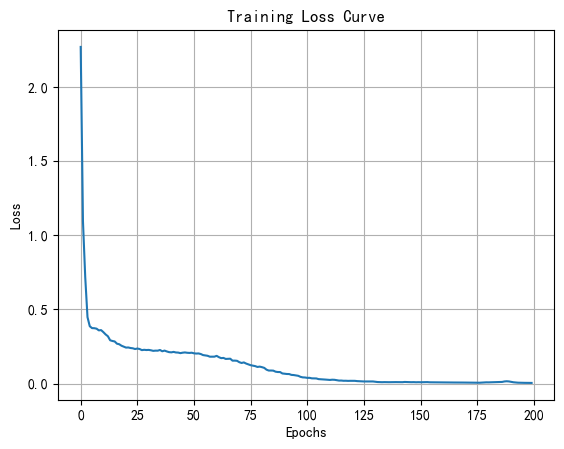

In [102]:
# 绘制损失曲线
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.title("Training Loss Curve")
plt.show()

In [103]:
def inverse_transform(scaled_data, scaler, feature_names):
    df = pd.DataFrame(scaled_data, columns=feature_names)
    return scaler.inverse_transform(df)

In [104]:
# 获取预测值 (LSTM)
lstm_model.eval()  # 切换到评估模式
# criterion = nn.MSELoss()  # 回归任务常用 MSELoss

# 初始化损失值
test_loss = 0.0
num_samples = 0

with torch.no_grad():
    y_pred_regression_test = lstm_model(torch.tensor(X_test, dtype=torch.float32)).detach()
    
    # 计算损失
    y_true = torch.tensor(y_regression_test, dtype=torch.float32)  # 真实值
    loss = criterion(y_pred_regression_test, y_true)  # 当前批次损失
    test_loss = loss.item()  # 累积损失
    y_pred_regression_test = y_pred_regression_test.numpy()  # 预测值
    

    
print('Test Loss: {:.6f}'.format(test_loss))

# 将真实值和预测值反归一化
y_true_original = inverse_transform(y_regression_test, scaler, features)
y_pred_original = inverse_transform(y_pred_regression_test, scaler, features)

Test Loss: 0.015750


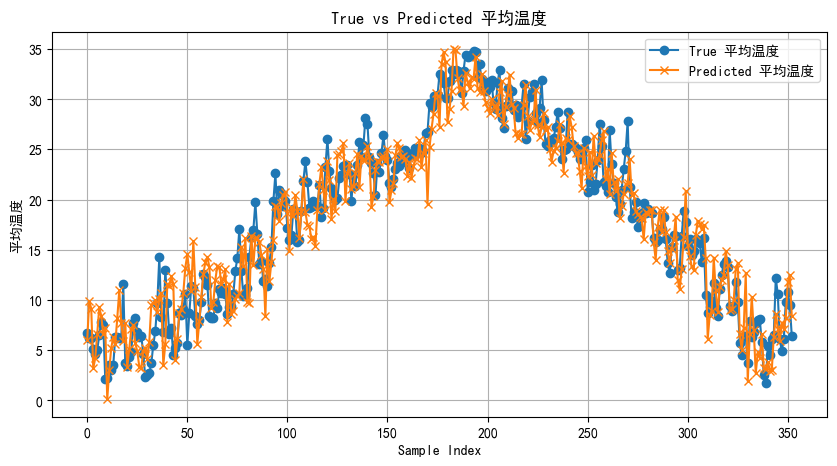

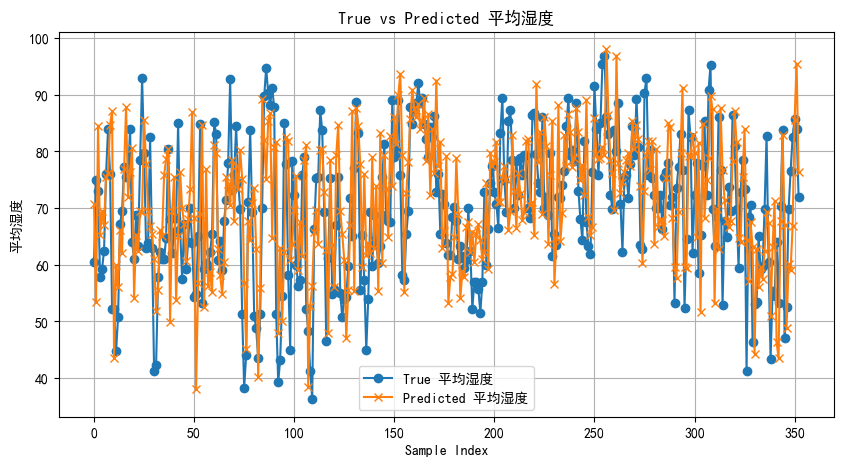

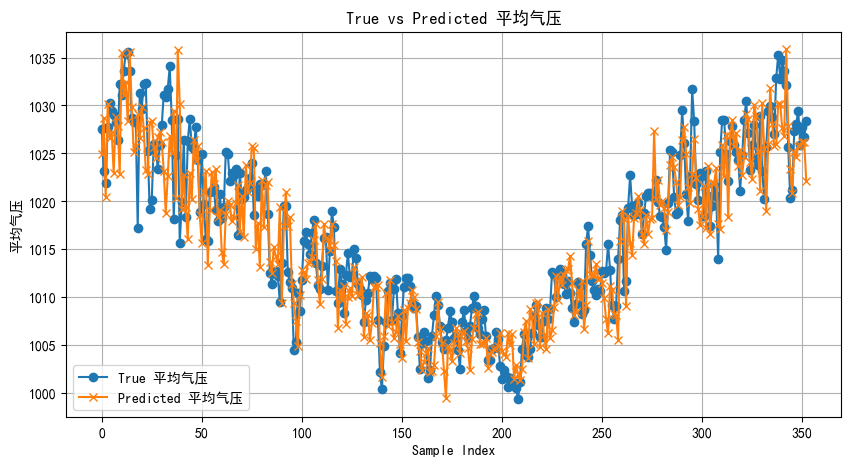

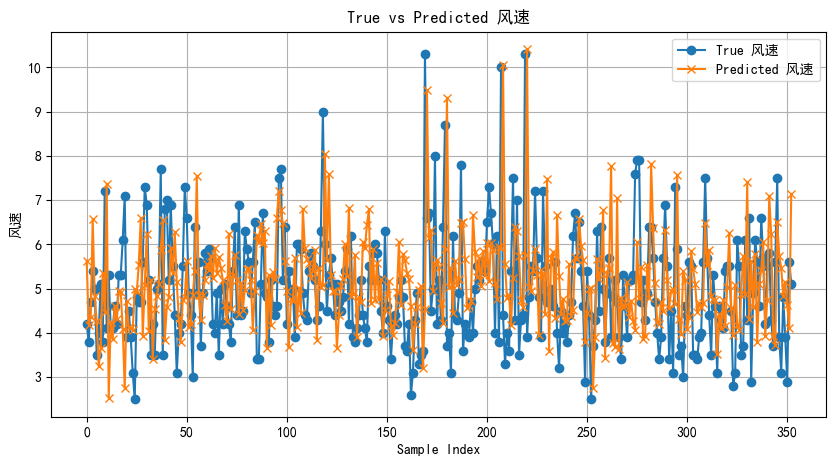

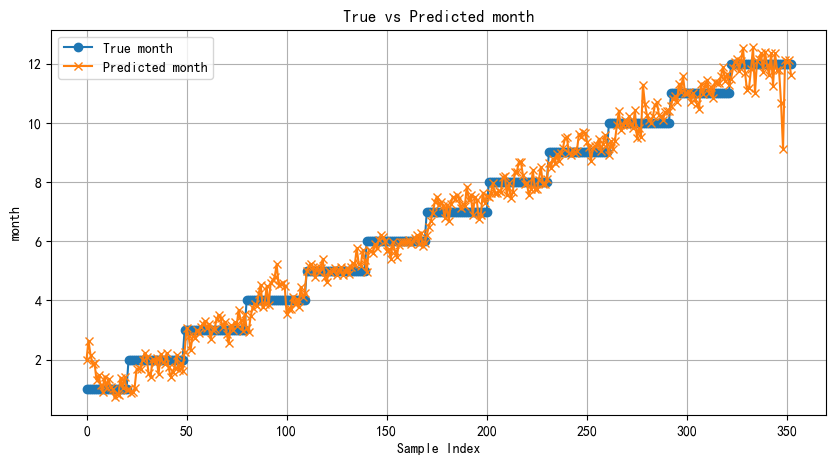

In [105]:
def plot_predictions(true_values, predicted_values, feature_names):
    """
    绘制真实值和预测值的对比折线图
    :param true_values: 真实值 (反归一化后)
    :param predicted_values: 预测值 (反归一化后)
    :param feature_names: 特征名称列表
    """
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        plt.plot(true_values[:, i], label=f"True {feature}", marker='o')
        plt.plot(predicted_values[:, i], label=f"Predicted {feature}", marker='x')
        plt.title(f"True vs Predicted {feature}")
        plt.xlabel("Sample Index")
        plt.ylabel(feature)
        plt.legend()
        plt.grid()
        plt.show()


# 可视化对比
plot_predictions(y_true_original, y_pred_original, features)

In [106]:
# class WeatherClassifier(nn.Module):
#     def __init__(self, input_size, num_classes):
#         """
#         初始化分类器模型
#         :param input_size: 输入特征维度(温度、湿度、大气压,3个特征)
#         :param num_classes: 天气类别数量
#         """
#         super(WeatherClassifier, self).__init__()
#         self.fc = nn.Sequential(# 定义网络结构
#             nn.Linear(input_size, 128),  # 输入层到隐藏层，128个隐藏单元
#             nn.ReLU(),                  # 激活函数
#             nn.Dropout(0.5),            # Dropout 防止过拟合
#             nn.Linear(128, 64),         # 第二层隐藏层
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, num_classes)  # 输出层，输出类别数量
#         )
#         self.softmax = nn.Softmax(dim=1)  # 输出每个类别的概率分布

#     def forward(self, x):
#         """
#         前向传播
#         :param x: 输入数据 (batch_size, input_size)
#         :return: 每个类别的概率分布 (batch_size, num_classes)
#         """
#         x = self.fc(x)
#         x = self.softmax(x)
#         return x

In [107]:
# from sklearn.utils.class_weight import compute_class_weight
# # 创建分类 Dataset

# class ClassifierDataset(Dataset):

#     def __init__(self, x_classification, y_classification):

#         self.X_predicted = torch.tensor(x_classification, dtype=torch.float32)

#         self.y_classification = torch.tensor(y_classification, dtype=torch.long)


#     def __len__(self):

#         return len(self.X_predicted)


#     def __getitem__(self, idx):

#         return self.X_predicted[idx], self.y_classification[idx]



# # 准备分类数据

# # X_predicted_train = lstm_model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()

# classifier_dataset = ClassifierDataset(x_classification, y_classification)

# classifier_loader = DataLoader(classifier_dataset, batch_size=64, shuffle=True)


# # 初始化分类器

# classifier = WeatherClassifier(input_size=input_s, num_classes=3)  # 假设8种天气类型

# # class_weights = compute_class_weight('balanced', classes = np.unique(y_classification), y = y_classification)
# # class_weights = torch.tensor(class_weights, dtype=torch.float32)
# criterion_cls = nn.CrossEntropyLoss()

# optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)


# num_epochs = 200

# batch_size = 32


# # 训练分类器

# for epoch in range(num_epochs):
#     classifier.train()

#     total_loss = 0


#     for X_batch, y_batch in classifier_loader:

#         optimizer_cls.zero_grad()


#         # 前向传播

#         outputs = classifier(X_batch)


#         # 计算分类损失

#         loss = criterion_cls(outputs, y_batch)

#         total_loss += loss.item()


#         # 反向传播和优化

#         loss.backward()

#         optimizer_cls.step()

#     # if (epoch+1) % 100 == 0:

#         # print(f"Epoch {epoch+1}, Classification Loss: {total_loss:.4f}")
        

In [108]:
# from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# classifier.eval()
# # 预测结果
# with torch.no_grad():
#     outputs = classifier(torch.tensor(x_classification_test, dtype=torch.float32))
#     outputs_classes = torch.argmax(outputs, dim=1)
#     # print(outputs)
#     # print(y_classification_test.shape)
    
# # 计算准确率
# accuracy = accuracy_score(outputs_classes.numpy(), y_classification_test)
# print(f"2017 年分类模型准确率: {accuracy:.4f}")

In [109]:
datas = pd.read_excel('recents.xlsx')

# 填充缺失值（如果有）
datas.fillna(method='ffill', inplace=True)

datas['date'] = pd.to_datetime(datas['date'])
# data['month'] = data['date'].dt.month


# 天气分类转换为数值

datas['天气编码'] = datas['天气'].map(weather_mapping)
print(datas)
# 标准化数值数据
scaler1 = MinMaxScaler()
datas[features] = scaler1.fit_transform(datas[features])

pred_data = []
seq = data.iloc[:10][features].values
pred_data.append(seq)
pred_data = np.array(pred_data)
# pred_data.shape
datas.head()


C:\Users\24048\AppData\Local\Temp\ipykernel_5280\892909768.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datas.fillna(method='ffill', inplace=True)


        date station city county        平均气压    风速    平均温度    平均湿度 天气  天气编码
0 2024-12-18      上海  上海市    宝山区  1025.98375  3.60  6.2750  63.750  阴     1
1 2024-12-19      上海  上海市    宝山区  1030.50125  7.50  5.8000  68.125  阴     1
2 2024-12-20      上海  上海市    宝山区  1031.28375  6.30  5.1000  63.500  阴     1
3 2024-12-21      上海  上海市    宝山区  1024.91750  4.50  4.7625  68.750  阴     1
4 2024-12-22      上海  上海市    宝山区  1028.25125  9.30  4.9750  49.875  阴     1
5 2024-12-23      上海  上海市    宝山区  1031.71750  6.30  4.6125  59.125  晴     0
6 2024-12-24      上海  上海市    宝山区  1029.53375  4.50  6.9375  66.250  晴     0
7 2024-12-25      上海  上海市    宝山区  1029.70000  4.50  7.1375  66.125  晴     0
8 2024-12-26      上海  上海市    宝山区  1026.98375  3.75  8.3500  80.250  晴     0
9 2024-12-27      上海  上海市    宝山区  1030.15000  7.50  7.4250  65.000  晴     0


KeyError: "['month'] not in index"

In [96]:
# 获取预测值 (LSTM)
lstm_model.eval()  # 切换到评估模式
# criterion = nn.MSELoss()  # 回归任务常用 MSELoss
num_samples = 0
pre_data = lstm_model(torch.tensor(pred_data, dtype=torch.float32)).detach()
outputs = classifier(torch.tensor(pre_data, dtype=torch.float32))
outputs_classes = torch.argmax(outputs, dim=1)

y_pre = inverse_transform(pre_data.numpy(), scaler, features)
print(f"预测值:{y_pre}")
print("12月28日的天气为")
print(f"平均温度预测值：{y_pre[0][0]:.2f},平均湿度预测值:{y_pre[0][1]:.2f}")
print(f"平均气压预测值:{y_pre[0][2]:.2f},风速预测值:{y_pre[0][3]:.2f}")
print(f"天气预测:{INV_weather_mapping[outputs_classes[0].item()]}")

预测值:[[  12.859406    94.69032   1050.975        4.6245694]]
12月28日的天气为
平均温度预测值：12.86,平均湿度预测值:94.69
平均气压预测值:1050.97,风速预测值:4.62
天气预测:阴


C:\Users\24048\AppData\Local\Temp\ipykernel_5280\3768722277.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = classifier(torch.tensor(pre_data, dtype=torch.float32))
